# Detecting heart arrythmias using anomaly detection
## Yngve Mardal Moe

In [23]:
import requests
import io
import itertools
from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from ipywidgets import interact

%matplotlib notebook

## Let us prepare the dataset
This is a famous arrythmia dataset, the original task was to detect arrythmias. However, it has been modified so the task at hand is to detect a collection of very rare arrythmias instead.

In [2]:
def load_csv_from_url(url, header='infer'):
    csv_str = requests.get(url).content.decode('utf-8')
    return pd.read_csv(io.StringIO(csv_str), index_col=0, header=header)

linear_X = load_csv_from_url('http://yngvem.no/arrythmia_linear.csv')
nominal_X = load_csv_from_url('http://yngvem.no/arrythmia_nominal.csv')
y = load_csv_from_url('http://yngvem.no/arrythmia_targets.csv', None)


In [3]:
train_linear_X, test_linear_X, train_nominal_X, test_nominal_X, train_y, test_y = train_test_split(
    linear_X,
    nominal_X,
    y,
    test_size=0.50
)

In [4]:
test_linear_X.head()

,Age: Age in years,Height: Height in centimeters,Weight: Weight in kilograms,QRS duration: Average of QRS duration in msec.,P-R interval: Average duration between onset of P and Q waves in msec.,Q-T interval: Average duration between onset of Q and offset of T waves in msec.,T interval: Average duration of T wave in msec.,P interval: Average duration of P wave in msec.,Heart rate: Number of heart beats per minute,"Q wave - Average width, in msec (DI)",...,QRSTA = QRSA + 0.5 * width of T wave * 0.1 * height of T wave. (If T is diphasic then the bigger segment is considered) (V5),"JJ wave - Amplitude , * 0.1 milivolt (V6)","Q wave - Amplitude , * 0.1 milivolt (V6)","R wave - Amplitude , * 0.1 milivolt (V6)","S wave - Amplitude , * 0.1 milivolt (V6)","R' wave - Amplitude , * 0.1 milivolt (V6)","P wave - Amplitude , * 0.1 milivolt (V6)","T wave - Amplitude , * 0.1 milivolt (V6)","QRSA , Sum of areas of all segments divided by 10, ( Area= width * height / 2 ) (V6)",QRSTA = QRSA + 0.5 * width of T wave * 0.1 * height of T wave. (If T is diphasic then the bigger segment is considered) (V6)
381,57.0,165.0,74.0,82.0,205.0,293.0,187.0,115.0,92.0,16.0,...,23.7,-0.6,0.0,9.3,-2.6,0.0,0.9,0.6,17.1,22.0
16,47.0,171.0,59.0,82.0,145.0,347.0,169.0,61.0,77.0,0.0,...,47.1,-0.4,0.0,9.4,-1.7,0.0,0.6,2.3,19.5,41.1
189,66.0,156.0,80.0,153.0,156.0,421.0,253.0,68.0,-20.0,0.0,...,14.8,-1.0,0.0,5.1,-1.9,0.0,0.2,-1.0,24.0,12.0
166,68.0,168.0,59.0,78.0,159.0,356.0,164.0,83.0,-51.0,0.0,...,42.3,-0.1,0.0,7.0,-2.7,0.0,0.4,2.6,6.2,31.1
167,19.0,156.0,47.0,80.0,137.0,342.0,243.0,92.0,-7.0,20.0,...,86.4,-0.4,-0.4,9.4,-1.4,0.0,1.3,4.3,16.1,71.1


## Let us explore the dataset
First, what is the contamination rate? That is, what is the outlier rate of this dataset?

In [5]:
print(f'The contamination rate is {train_y.mean().iloc[0]:.2f}')

The contamination rate is 0.16


Let us now visualise our dataset, using an interactive matplotlib plot. 

PS. sometimes, it takes several attemts at `%matplotlib notebook` for it to work

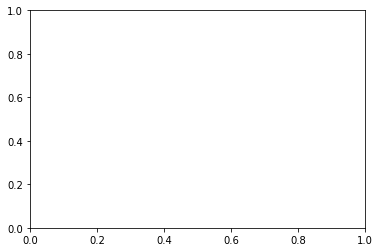

A Jupyter Widget

In [6]:
fig = plt.figure()
sub = plt.subplot()

@interact(x_col=train_linear_X.columns, y_col=train_linear_X.columns)
def replot(x_col, y_col):
    sub.clear()
    sub.scatter(train_linear_X[x_col], train_linear_X[y_col], s=5)

From this, we see that there are many missing values that are set to zero. This is not ideal for the case at hand and will make it more difficult for us to find outliers (there will probably be a fair amount of false positives as well)

## Let us save some lives!

In [7]:
scaler = StandardScaler()
train_linear_X[:] = scaler.fit_transform(train_linear_X)
test_linear_X[:] = scaler.transform(test_linear_X)

train_X = pd.concat([train_linear_X, train_nominal_X], axis=1)
test_X = pd.concat([test_linear_X, test_nominal_X], axis=1)

/home/yngve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yngve/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(key, value)
/home/yngve/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return self._setitem_s

## Local Outlier Factor

In [8]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.15)
train_lof_prediction = lof.fit_predict(train_X)
test_lof_prediction = lof._predict(test_X)    # Error in sklearn API so predict is missing...

### Plotting confusion matrix to assess results

In [9]:
train_lof_cm = metrics.confusion_matrix(1 - 2*train_y, train_lof_prediction)
test_lof_cm = metrics.confusion_matrix(1 - 2*test_y, test_lof_prediction)

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

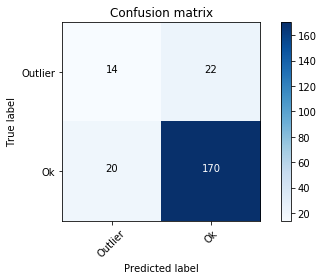

In [11]:
plot_confusion_matrix(train_lof_cm, ['Outlier', 'Ok'])

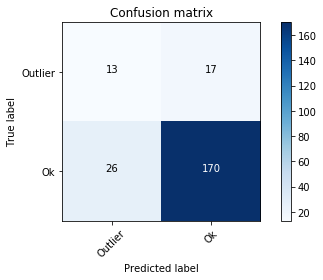

In [12]:
plot_confusion_matrix(test_lof_cm, ['Outlier', 'Ok'])

### Conclusion from Local Outlier Factor
LOF worked well on the training data, but not the test set. This is strange as it is an unsupervised method and indicates that we do not have enough training data.

## Isolation Forest

In [13]:
iforest = IsolationForest(contamination=0.15)
iforest.fit(train_X)

train_if_prediction = iforest.predict(train_X)
test_if_prediction = iforest.predict(test_X)

In [14]:
train_if_cm = metrics.confusion_matrix(1 - 2*train_y, train_if_prediction)
test_if_cm = metrics.confusion_matrix(1 - 2*test_y, test_if_prediction)

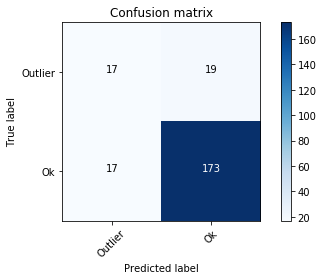

In [15]:
plot_confusion_matrix(train_if_cm, ['Outlier', 'Ok'])

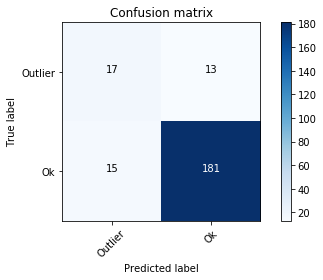

In [16]:
plot_confusion_matrix(test_if_cm, ['Outlier', 'Ok'])

In [68]:
from ipywidgets import IntSlider, Checkbox, HBox
from IPython.display import display
import scipy

class LOFVisualiser:
    def __init__(self):
        self.dataset = self._generate_dataset()
        self.distances = scipy.spatial.distance_matrix(self.dataset, self.dataset)
        
        self.fig = plt.figure()
        self.sub = self.fig.add_subplot(111)
        self.sub.scatter(self.dataset[:, 0], self.dataset[:, 1])
        self.fig.canvas.mpl_connect('button_press_event', self.press_button)
        
        self.k_slider = IntSlider(min=1, max=15, value=3)
        self.k_slider.on_trait_change(self.update_lof_visualisation)
        self.neighbouring_densities = Checkbox(description='Show neighbouring densities')
        self.neighbouring_densities.on_trait_change(self.update_lof_visualisation)
        display(HBox([self.k_slider, self.neighbouring_densities]))
        
        self.idx = 0
        self.previous_k = 3

        self.lof = LocalOutlierFactor(n_neighbors=self.k_slider.value)
        self.lof.fit(self.dataset)
    
    @property
    def current_lof(self):
        """The local outlier factor of the currently selected point.
        """
        if self.previous_k != self.k_slider.value:
            self.lof = LocalOutlierFactor(n_neighbors=self.k_slider.value)
            self.lof.fit(self.dataset)
        current_sample = self.dataset[self.idx]
        return -self.lof._decision_function(current_sample.reshape(1, -1))[0]
    
    @staticmethod
    def _generate_dataset():
        """Generate a bimodal dataset with two outliers.
        """
        synthetic_X = 0.7*np.random.randn(100) + 1
        synthetic_Y = 2*np.random.randn(100) + 2

        synthetic_X_2 = 0.2*np.random.randn(50) - 5
        synthetic_Y_2 = 0.4*np.random.randn(50) + 3

        outlier_X = 0.3*np.random.randn(1) - 3
        outlier_Y = 0.3*np.random.randn(1) - 2

        outlier_X_2 = 0.3*np.random.randn(1) - 4.5
        outlier_Y_2 = 0.3*np.random.randn(1) + 1

        return np.stack((np.concatenate((synthetic_X, synthetic_X_2, outlier_X, outlier_X_2)),
                         np.concatenate((synthetic_Y, synthetic_Y_2, outlier_Y, outlier_Y_2))),
                        axis=1)

    def get_kth_nearest(self, idx):
        """Find the index of the kth nearest neighbour for datapoint number `idx`
        """
        distances = self.distances[idx]
        k = self.k_slider.value
        return sorted(enumerate(distances), key=itemgetter(1))[k][0]

    def find_nearest_idx(self, click_point):
        """Find the nearest datapoint to the clicked position
        """
        distances = np.linalg.norm(self.dataset - np.reshape(click_point, (1, -1)), axis=1)
        return sorted(enumerate(distances), key=itemgetter(1))[0][0]
    
    def draw_density_circle(self, idx, draw_neighbours=False, plot_radius=True, color='red'):
        """Draw a circle around the given point, radius equal to the distance to the kth neighbour
        """
        k = self.k_slider.value
        distances = self.distances[idx]
        kth_idx = self.get_kth_nearest(idx)
        
        circle = plt.Circle(self.dataset[idx], distances[kth_idx], 
                            fill=False, color=color)
        self.sub.add_artist(circle)
        
        if plot_radius:
            relevant_points = self.dataset[(idx, kth_idx), :]
            self.sub.plot(relevant_points[:, 0], relevant_points[:, 1], color=color)
        
        if draw_neighbours:
            for i in range(1, 1+k):
                ith_nearest_idx = get_kth_nearest(self.dataset, idx, i)
                self.draw_density_circle(ith_nearest_idx, draw_neighbours=False,
                                         plot_radius=False, color='green')
        
    def update_lof_visualisation(self):
        """Update the visualisation
        """
        self.sub.clear()
        self.sub.set_title(f'Local outlier factor: {self.current_lof:.2f}')
        
        self.sub.scatter(self.dataset[:, 0], self.dataset[:, 1])
        self.sub.scatter(self.dataset[self.idx, 0], self.dataset[self.idx, 1])
        self.draw_density_circle(self.idx, self.neighbouring_densities.value)
        
    def press_button(self, event):
        """On click events, updates visualisation.
        """
        xy = np.array((event.xdata, event.ydata))
        self.idx = find_nearest(self.dataset, xy)
        
        self.update_lof_visualisation()

<IPython.core.display.Javascript object>


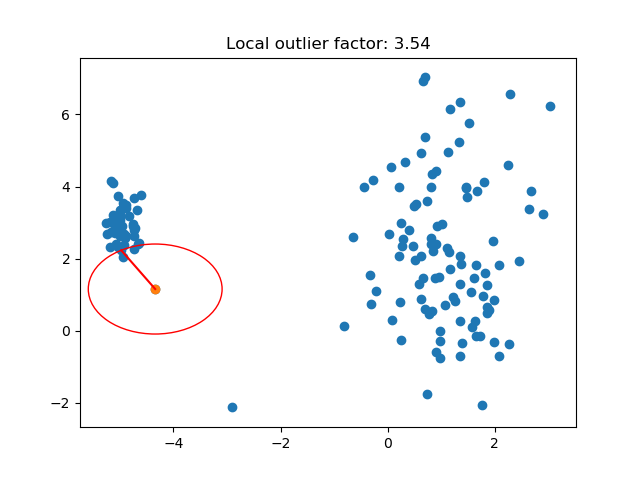

/home/yngve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  app.launch_new_instance()
/home/yngve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead


A Jupyter Widget

In [69]:
LOFVisualiser()

In [20]:
!pip install sklearn

In [21]:
distances = np.sqrt((synthetic_X - outliers_X)**2 + (synthetic_Y - outliers_Y)**2)

NameError: name 'outliers_X' is not defined

In [ ]:
sorted(enumerate(distances), key=itemgetter(1))[:3]

In [27]:
from operator import itemgetter


In [ ]:
a.sub.clear()

In [ ]:
find_nearest(a.dataset, a.dataset[1])

In [ ]:
a.sub.add_artist()